# Single Server Example to show Metastability

In [1]:
# IMPORTANT: THE PATH IS CURRENTLY HARDCODED. CHANGE IT TO POINT TO YOUR LOCAL COPY OF `metafor`
import os, sys
sys.path.append("/Users/rupak/Code/metafor")
sys.path.append("/Users/rupak/Code/metafor/metafor")
sys.path.append(".")

In [ ]:
import math
import numpy as np
from numpy import linspace
import pandas
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from metafor.dsl.dsl import Server, Work, Source, Program
from metafor.model.single_server.ctmc import SingleServerCTMC
from metafor.analysis.experiment import Parameter, ParameterList
from metafor.analysis.visualize import Visualizer


## Defining the program

In [8]:


def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=1000, orbit_size=3, thread_pool=100)
        src = Source('client', 'insert', 6200, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

def basic_stats(p: Program):
        p.print()
        print("Building CTMC")
        ctmc: SingleServerCTMC = p.build()
        print("Computing stationary distribution")
        pi = ctmc.get_stationary_distribution()
        print("Average queue size = ", ctmc.main_queue_size_average(pi))
        print("Mixing time = ", ctmc.get_mixing_time())
        # S1 = ctmc.set_construction([[0, int(.3*ctmc.main_queue_size)]], [[0, ctmc.retry_queue_size]])
        # S2 = ctmc.set_construction([[int(.9*ctmc.main_queue_size), ctmc.main_queue_size]], [[0, ctmc.retry_queue_size]])
        S1 = ctmc.set_construction([[0, int( 0.5 * ctmc.main_queue_size) ]], [[0, ctmc.retry_queue_size-1]])
        S2 = ctmc.set_construction([[int(0.95 * ctmc.main_queue_size), ctmc.main_queue_size-1]], [[0, ctmc.retry_queue_size-1]])
        ht_su = ctmc.get_hitting_time_average(S1, S2)
        ht_us = ctmc.get_hitting_time_average(S2, S1)
        print("Expected hitting time to go from high to low mode is", ht_us)
        print("Expected hitting time to go from low to high mode is", ht_su)

In [9]:
p = program()
basic_stats(p)

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 1000 orbit 3 threads 100]
Sources:  	 client: generates insert: (arr 6200.000000, to 3, re 4)
Building CTMC
Program:  Service52 , Number of states =  3000
Computing stationary distribution
Average queue size =  [210.8810831]
[-24900.49434821+0.j -24900.26923264+0.j -24900.158918  +0.j ...
  -3578.40421458+0.j  -4048.25060257+0.j  -3291.36503831+0.j]
Sorted eigenvalues (real parts): [-2.65195643e-11 -1.74183054e-01 -3.33332988e-01 ... -2.49001589e+04
 -2.49002692e+04 -2.49004943e+04]
Mixing time =  38.142953813127086
Maximum error in solving the linear equation is 1.7136335372924805e-07
Maximum error in solving the linear equation is 9.458744898438454e-11
Expected hitting time to go from high to low mode is 7.392273953317682
Expected hitting time to go from low to high mode is 2469.39354726378


## Running parameter sweeps.

We define ``full queue'' to be a state where more than  98% of the queue is full. The hitting time experiment checks what is the expected time to go from a full queue to a queue that is only 80% full. 
(TODO: We should make these numbers parameterized, and also check how long it takes to go back to the average queue length.)

In [ ]:
from metafor.analysis.single_server.latency_experiment import HittingTimeExperiment


def test_hitting_times(p):
    qsizes = Parameter(("server", "52", "qsize"), range(16000, 22000, 1000))
    print("Computing exact recovery times")
    ht = HittingTimeExperiment(p)
    ht.sweep(ParameterList([qsizes]))


## TAKES TOO LONG FOR LONG QUEUES
# test_hitting_times(program())

## Visualizing the dynamics. 

The following code is under construction may be buggy at this point.

The idea is that instead of actually computing the hitting times, we visualize the "general direction" of the dynamics. It seems that this visualization is quite useful to figure out what parameters to simulate.

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 20000 orbit 1000 threads 100]
Sources:  	 client: generates insert: (arr 6200.000000, to 3, re 4)
found solution is [17430.13286276   187.53943182]
obj value is 0.0001825345679718685
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


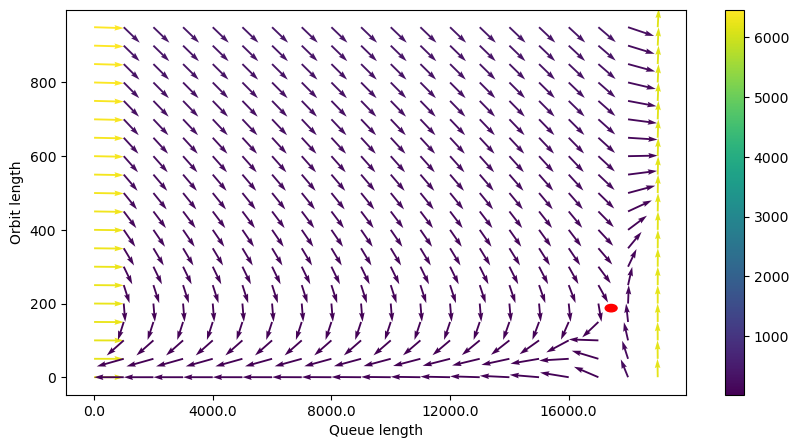

In [10]:
def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=20000, orbit_size=1000, thread_pool=100)
        src = Source('client', 'insert', 6200, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

v = Visualizer(program())
v.visualize(show_equilibrium=True)

Prediction: One should see a metastable behavior for a queue size around 20000 and orbit around 50.

Unfortunately, these experiments take *a long* time to run --- so we can try to reproduce similar behaviors on a scaled down version of the system.

In [11]:
def scaled_program():
        # essentially scale down rates by a 100
        
        api = { "insert": Work(.625, [],) }
        server = Server("52", api, qsize=200, orbit_size=10, thread_pool=100)
        src = Source('client', 'insert', 62, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

sp = scaled_program()

In [12]:
basic_stats(sp)


Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 200 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Building CTMC
Program:  Service52 , Number of states =  2000
Computing stationary distribution
Average queue size =  [173.49013472]
[-1.63573590e-13+0.j         -2.67493928e+02+4.29966585j
 -2.67493928e+02-4.29966585j ... -5.95804619e+01+0.j
 -6.07682103e+01+0.35611578j -6.07682103e+01-0.35611578j]
Sorted eigenvalues (real parts): [-1.63573590e-13 -3.75489732e-02 -2.11427572e-01 ... -2.66448107e+02
 -2.67493928e+02 -2.67493928e+02]
Mixing time =  176.93842537109091
Maximum error in solving the linear equation is 4.547473508864641e-12
Maximum error in solving the linear equation is 2.9103830456733704e-11
Expected hitting time to go from high to low mode is 369.6312851974193
Expected hitting time to go from low to high mode is 48.440430457307535


We now try to see how long it takes for a full queue to become small, as the size of the queue increases.

In [13]:
def test_hitting_times_scaled(p):
    qsizes = Parameter(("server", "52", "qsize"), range(500, 2000, 100))
    print("Computing exact recovery times")
    ht = HittingTimeExperiment(p)
    ht.sweep(ParameterList([qsizes]))

test_hitting_times_scaled(sp)

Computing exact recovery times


Running experiment with parameters  {'server': {'52': {'qsize': 500}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 500 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  5000
Maximum error in solving the linear equation is 5.820766091346741e-11
Analysis time =  2.3758881092071533  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 600}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 600 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  6000
Maximum error in solving the linear equation is 1.4551915228366852e-10
Analysis time =  3.324547052383423  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 700}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 700 or

Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@0.625000 [q 200 orbit 10 threads 100]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
found solution is [100.89798618   2.22577702]
obj value is 0.014468611706822978
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


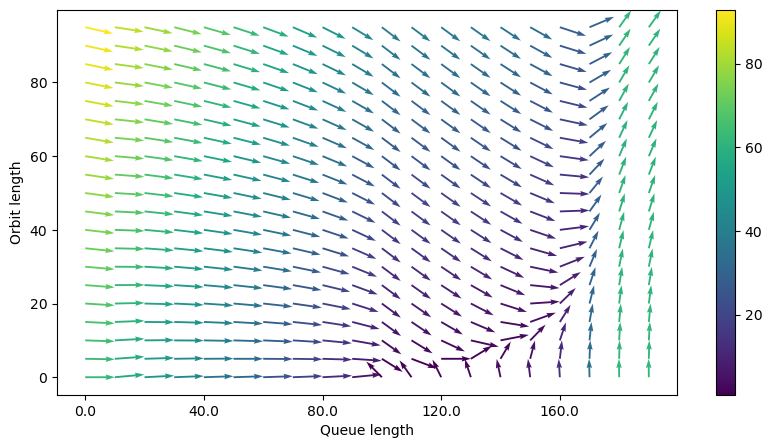

In [14]:
sp = scaled_program()
v = Visualizer(sp)
v.visualize(qrange=200, orange=100, show_equilibrium=True)

The previous experiment on Hitting times checked how long it takes to go from 98% full queue to 80% full queue. This may not be a very good indicator, we should see how long it takes for a full queue to get back to average queue size in normal mode. The next experiment checks this.

In [17]:
from metafor.analysis.experiment import Experiment


class SweepHittingTimes(Experiment):
    def __init__(self, p: Program, lowfactor: float=0.8, hifactor: float=0.98):
        self.p = p

        self.lowfactor = lowfactor
        self.fullfactor = hifactor

        self.main_color = "#A9A9A9"
        self.fade_color = "#D3D3D3"

    def plot(
            self,
            figure_name: str,
            x_axis: str,
            y_axis: str,
            x_vals,
            hitting_times,
    ):
        plt.rc("font", size=14)
        plt.rcParams["figure.figsize"] = [5, 5]
        plt.rcParams["figure.autolayout"] = True

        plt.figure()  # row 0, col 0
        plt.plot(x_vals, hitting_times, color=self.main_color)

        plt.xlabel(x_axis, fontsize=14)
        plt.ylabel(y_axis, fontsize=14)
        plt.grid("on")
        plt.xlim(min(x_vals), max(x_vals))
        plt.show()
        plt.close()

    def build(self, param) -> Program:
        return self.update(self.p, param)

    def analyze(self, param_setting, p: Program):
        ctmc = p.build()
        pi = ctmc.get_stationary_distribution()
        qavg = ctmc.main_queue_size_average(pi)[0]
        print("Average queue = ", qavg)
        # average = ctmc.set_construction([[0, int(1 * ctmc.thread_pool)]], [[0, ctmc.retry_queue_size]])
        # average = ctmc.set_construction([[0, 100]], [[0, ctmc.retry_queue_size]])
        average = ctmc.set_construction([[0, int(self.lowfactor * qavg)]], [[0, ctmc.retry_queue_size - 1]])
        full = ctmc.set_construction([[int(self.fullfactor * ctmc.main_queue_size), ctmc.main_queue_size - 1]],
                                   [[0, ctmc.retry_queue_size - 1]])
        
        hitting_time = ctmc.get_hitting_time_average(full, average)
        print("Param setting = ", param_setting, " Hitting time = ", hitting_time)
        return [param_setting, hitting_time]

    def show(self, results):
        # print(results)
        PARAMETER = "parameter"
        HITTING_TIME = "Hitting time"
        columns = [PARAMETER, HITTING_TIME]

        pd = pandas.DataFrame(results, columns=columns)

        print(pd)

In [16]:
from metafor.analysis.single_server.latency_experiment import MixingTimeExperiment


def scaled_program():
        api = { "insert": Work(62.5, [],) }
        server = Server("52", api, qsize=300, orbit_size=20, thread_pool=1)
        src = Source('client', 'insert', 62, timeout=3, retries=4)
        p = Program("Service52")
        p.add_server(server)
        p.add_source(src)
        p.connect('client', '52')
        return p

sp = scaled_program()
# ctmc: SingleServerCTMC = sp.build()
# print("Computing stationary distribution")
# pi = ctmc.get_stationary_distribution()
# q_avg = ctmc.main_queue_size_average(pi)
# print("Average queue size = ", q_avg)

# print("Getting mixing times...", ctmc.get_mixing_time())

# S1 = ctmc.set_construction([[0, int( 0.5 * ctmc.main_queue_size) ]], [[0, ctmc.retry_queue_size-1]])
# S2 = ctmc.set_construction([[int(0.95 * ctmc.main_queue_size), ctmc.main_queue_size-1]], [[0, ctmc.retry_queue_size-1]])
## ht_su = ctmc.get_hitting_time_average(S1, S2)
# ht_us = ctmc.get_hitting_time_average(S2, S1)
# print("Expected hitting time to go from high to low mode is", ht_us)
## print("Expected hitting time to go from low to high mode is", ht_su)


# As queues get large, hitting times should 
qsizes = Parameter(("server", "52", "qsize"), range(150, 450, 50))
t = SweepHittingTimes(sp, 0.8, 0.98) # how much time does it take a 98% filled queue to get to 80% of the average queue
t.sweep(ParameterList([qsizes]))





Running experiment with parameters  {'server': {'52': {'qsize': 150}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 150 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3000
Average queue =  68.6337215998536
Maximum error in solving the linear equation is 7.275957614183426e-12
Param setting =  {'server': {'52': {'qsize': 150}}}  Hitting time =  79.65363966185136
Analysis time =  16.66222310066223  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 200}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 200 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  4000
Average queue =  181.66141963093943
Maximum error in solving the linear equation is 2.9103830456733704e-11
Param setting =  {'server': {'52': {'qsize': 200}}}  Hitting time =  332.66638

In [ ]:
sp = scaled_program()
# checking queue sizes around the point in which the latency is around 3 time units

qsizes = Parameter(("server", "52", "qsize"), range(180, 190, 1))
t = SweepHittingTimes(sp, 0.8, 0.98) # how much time does it take a 98% filled queue to get to 80% of the average queue
t.sweep(ParameterList([qsizes]))



Running experiment with parameters  {'server': {'52': {'qsize': 180}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 180 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3600
Average queue =  138.56090939039194
Maximum error in solving the linear equation is 2.9103830456733704e-11
Param setting =  {'server': {'52': {'qsize': 180}}}  Hitting time =  297.06675039361545
Analysis time =  21.66846203804016  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 181}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 181 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3620
Average queue =  141.46738130134236
Maximum error in solving the linear equation is 2.1827872842550278e-11
Param setting =  {'server': {'52': {'qsize': 181}}}  Hitting time =  300.2

In [ ]:
# Mixing time is an approximate measure of the hitting time... this is useful when the hitting time is hard to compute
# because the linear system does not converge quickly.
# Mixing time computation needs finding the second largest eigenvalue of the matrix
sp = scaled_program()
qsizes = Parameter(("server", "52", "qsize"), range(160, 200, 10))

t = MixingTimeExperiment(sp)
t.sweep(ParameterList([qsizes]))




Running experiment with parameters  {'server': {'52': {'qsize': 160}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 160 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3200
[-2.59347841e+02+0.j          7.00859809e-13+0.j
 -2.57845837e+02+0.02564745j ... -1.66452788e+01+0.j
 -1.66416038e+01+0.j         -1.16234472e+01+0.j        ]
Sorted eigenvalues (real parts): [ 7.00859809e-13 -1.67546955e-02 -8.10099441e-02 ... -2.57845837e+02
 -2.57845837e+02 -2.59347841e+02]
Analysis time =  18.808279037475586  seconds
Running experiment with parameters  {'server': {'52': {'qsize': 170}}}
Program:  Service52
client 	 -->	  52
Servers:  	 52: serves insert@62.500000 [q 170 orbit 20 threads 1]
Sources:  	 client: generates insert: (arr 62.000000, to 3, re 4)
Program:  Service52 , Number of states =  3400
[-262.59609304+0.j         -260.93278686+0.j
 -259.6104208 +0.06388265j ...  -2

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [70.91688165 15.49428048]
obj value is 0.002965513293409599
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


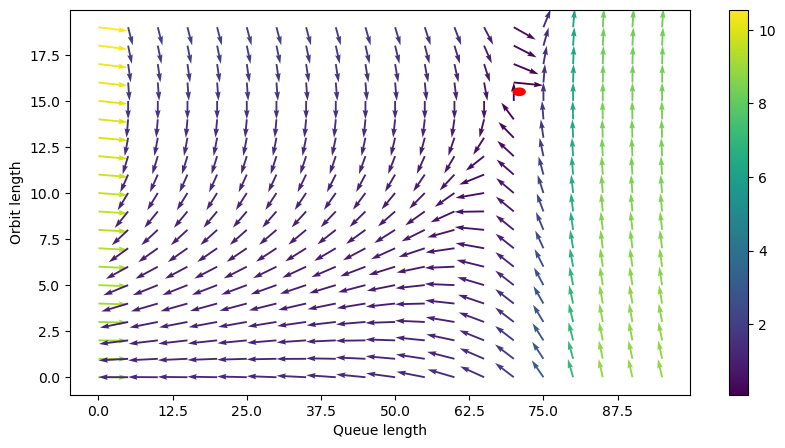

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 4.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [65.14658826  9.23573032]
obj value is 0.0006371402372142525
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


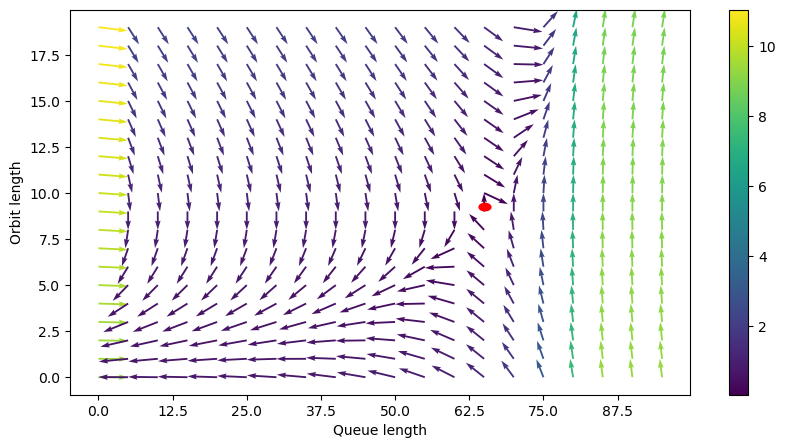

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [51.38880116  3.01140281]
obj value is 1.4465114305858412e-06
Optimization terminated successfully.
found an almost equilibrium point


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


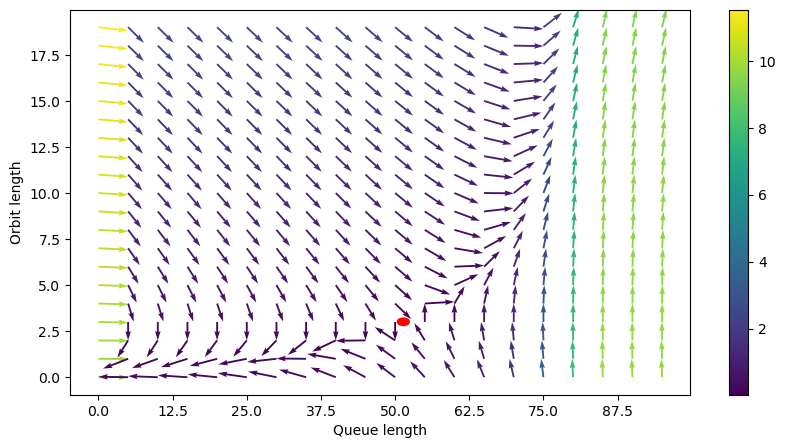

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 5.500000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [4.29086255 0.        ]
obj value is 0.06253073080299204
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


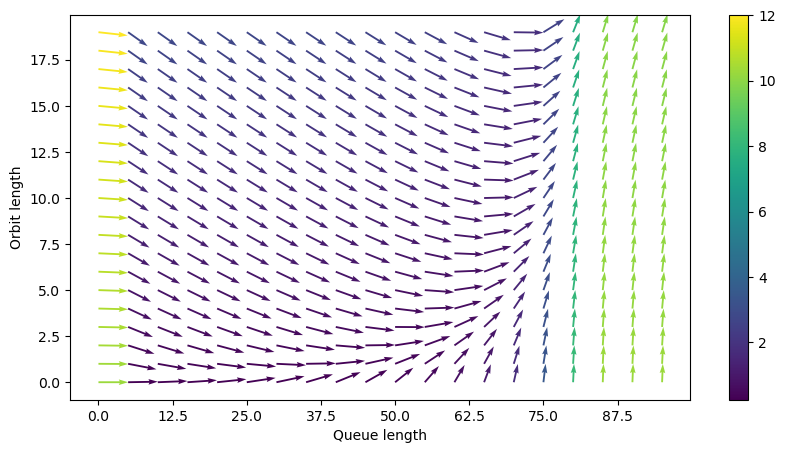

Program:  Service52
client-i 	 -->	  52
client-d 	 -->	  52
Servers:  	 52: serves insert@10.000000,delete@10.000000 [q 100 orbit 10 threads 1]
Sources:  	 client-i: generates insert: (arr 6.000000, to 9, re 3)
	 client-d: generates delete: (arr 4.750000, to 9, re 3)
found solution is [1.89820158 0.        ]
obj value is 0.5625018418612112
Optimization terminated successfully.


/Users/rupak/Code/metafor/metafor/analysis/visualize.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(scaled_xticks)


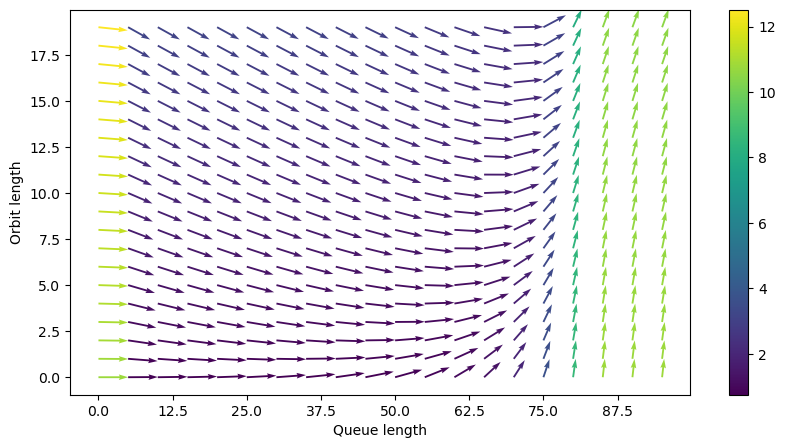

In [18]:


def program():
        # api = { "insert": Work(1/.016, [],) }
        api = { "insert": Work(10, [],), "delete": Work(10, []) }
        server = Server("52", api, qsize=100, orbit_size=10, thread_pool=1)
        src1 = Source('client-i', 'insert', 4.75, timeout=9, retries=3)
        src2 = Source('client-d', 'delete', 4.75, timeout=9, retries=3)

        p = Program("Service52")

        p.add_server(server)
        p.add_sources([src1, src2])
        p.connect('client-i', '52')
        p.connect('client-d', '52')
        return p

v = Visualizer(program())
p = Parameter(('source', 'client-i', 'arrival_rate'), linspace(4, 6, 5))
v.visualize(ParameterList([p]), qrange=100, orange=20, show_equilibrium=True)